Author: Sooheon Kim 


KAICD

2020/11

# Agenda

이 노트북 완성하면 배워가실 것:

1. Molecule dataset 만들어 활용
2. 분자 그래프를 처리할 수 있는 GNN
3. 사전학습된 GNN 활용하여 embedding 진행
    - Pooling 개념
4. 사전학습된 Transformer 활용하여 embedding 진행
5. Mol/Prot Embedding을 융합하여 Co-attentive pooled embeddings 생성
    - 이를 활용한 interaction prediction


이 교육에서 다루지 *않는* 부분:

1. Training loop 형성, dataset split등 학습 과정 detail

# Env

In [104]:
!nvidia-smi

Tue Nov 10 11:51:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   81C    P0    46W /  70W |   6501MiB / 15079MiB |      3%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [105]:
!pip install dgl-cu101 dgllife ogb seaborn transformers nx_altair

In [106]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/opt/
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
sudo ./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
conda install --channel defaults conda python=3.6 --yes
conda update --channel defaults --all --yes
conda install -c rdkit rdkit --yes

PREFIX=/opt
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11.0-py3

--2020-11-10 11:51:28--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2020-11-10 11:51:28--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh.1’

     0K .......... .......... .......... .......... ..........  0% 59.0M 1s
    50K .......... .......... .......... .......... ..........  

In [107]:
# add conda packages to path
import sys
sys.path.append('/opt/lib/python3.6/site-packages/')

In [108]:
!export DGLBACKEND=pytorch

# Molecule Data Featurization

여태까지는 sample graph 하나를 다루면 여러가지 featurization 방법을 보셨습니다. Featurization scheme을 결정하시고 나서는 
1. Training Set을 다 동일하게 전처리 진행, 그리고
2. 처리된 데이터를 학습할 수 있도록 Loading 하는 작업이 필요합니다.

Graph를 처리하고 loading하는 것이 약간 낯설 수 있으나, 조금만 해보면 img/txt데이터와 크게 다를 것 없습니다.

In [109]:
import dgl
import rdkit
import dgllife
import torch as th
from torch import nn

우선은 Graph Dataset 예시를 한번 본 후 이를 간단하게 재구현 해보겠습니다. 

이미지에 MNIST가 있다면 이제 graph데이터에는 [OGB](https://github.com/vibudh2209/D2)가 있습니다. Node/Edge/Graph 용 데이터셋이 지금 정리되어있는데, 이 중 Graph Property Prediction에는 chemistry 관련 데이터셋 몇개 찾을 수 있습니다.

<img src='https://drive.google.com/uc?id=1dMydWvdIFDg5r_V_iDiSSaRkFRg-8tBL' height=300/>

In [110]:
from ogb.graphproppred import DglGraphPropPredDataset
ds = DglGraphPropPredDataset(name='ogbg-mollipo')

In [111]:
ds[0]

(Graph(num_nodes=24, num_edges=54,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 tensor([3.5400]))

이 데이터셋은 (graph, y) pair로 구성되어있네요. Graph에서 꺼꾸로 Mol을 찾으시려면 상당히 번거롭게 생겼는데, 이래서 데이터 셋 처리 첫 원칙은 

> "Raw 데이터 절대 버리지 말 것"

입니다.

OGB에서도 이를 알고 있어서, dataset attribute에 조금만 찾아보면 raw data를 찾을 수 있습니다.

`dataset.root > mapping > mol.csv.gz`

In [112]:
!ls {ds.root}

mapping  processed  raw  RELEASE_v1.txt  split


In [113]:
!ls {ds.root}/'mapping'

mol.csv.gz  README.md


In [114]:
from pathlib import Path
import pandas as pd

df = pd.read_csv(Path(ds.root) / 'mapping/mol.csv.gz').drop('mol_id', axis=1)

print(df.shape)
df.head()

(4200, 2)


,exp,smiles
0,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


Visualize Mol with RDKit, and visualize resulting graph with NetworkX.

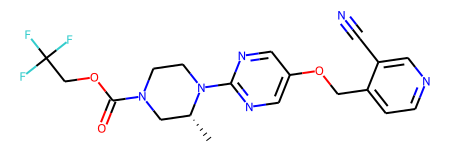

In [115]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True

import networkx as nx

# import random
# i = random.choice(range(len(df)))
i = 1247

def draw_dgl_graph(g, k='feat', **kwargs):
  "use networkx to draw graph structure"
  data = g.ndata[k]
  data = data.reshape(data.shape[0], -1).float().mean(-1)
  nx.draw_networkx(g.to_networkx(), arrows=False, node_color=data, cmap='tab20',
                   vmin=data.min(), vmax=data.max(), **kwargs)

Chem.MolFromSmiles(df['smiles'][i])

동일 분자의 graph representation

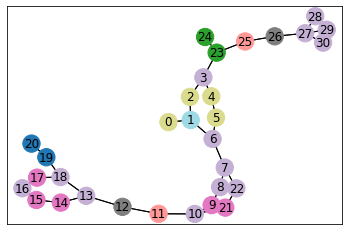

In [116]:
draw_dgl_graph(ds[i][0])

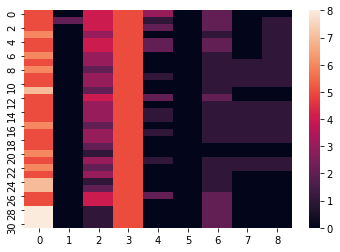

In [117]:
import seaborn as sns 
sns.heatmap(ds[i][0].ndata['feat'])

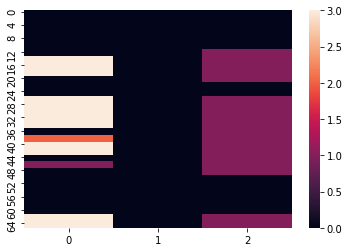

In [118]:
sns.heatmap(ds[i][0].edata['feat'])

Node feature 9개, edge feature 3개가 있네요. 어떻게 이게 만들어졌는지는 전수업 듣고 어느정도 감이 잡히셨을텐데, 구체적으로 이들이 어떻게 구현했냐는 좀 코드 발굴필요합니다.

In [119]:
from ogb.utils.features import allowable_features
import pprint

pprint.pprint(list(allowable_features.keys()))

['possible_atomic_num_list',
 'possible_chirality_list',
 'possible_degree_list',
 'possible_formal_charge_list',
 'possible_numH_list',
 'possible_number_radical_e_list',
 'possible_hybridization_list',
 'possible_is_aromatic_list',
 'possible_is_in_ring_list',
 'possible_bond_type_list',
 'possible_bond_stereo_list',
 'possible_is_conjugated_list']


이정도면 mol을 충분히 표현했다고 생각이 드시나요?

### HOMEWORK

- 전 수업의 Node/Edge Featurizer 코드와 위에 읽어드린 raw data csv파일 (SMILES)로 원하는 형태의 featurization 된 데이터셋 생성하세요.

아래에는 dgllife 패키지의 featurization 코드를 활용 진행하겠으나, 자유로운 featurization은 chem data로 ml 하시는데에 가장 기초입니다. (text token으로 처리하지 않으실것이면)

## Mol->Graph helper functions

Mol object를 graph형식으로 읽어드리는 작업은 자주하니, dgllife (또는 deepchem 등등) 같은 lib로 반복적인 작업 encapsulate하는 것을 추천드립니다.

In [120]:
from functools import partial
from dgllife.utils import mol_to_bigraph, mol_to_complete_graph, \
    PretrainAtomFeaturizer, PretrainBondFeaturizer

molgraph = partial(mol_to_bigraph, 
                   add_self_loop=True,
                   node_featurizer=PretrainAtomFeaturizer(),
                   edge_featurizer=PretrainBondFeaturizer(self_loop=True),
                   canonical_atom_order=False)

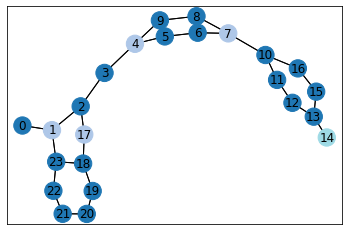

In [121]:
mol = Chem.MolFromSmiles(df['smiles'][0])
draw_dgl_graph(molgraph(mol),'atomic_number')

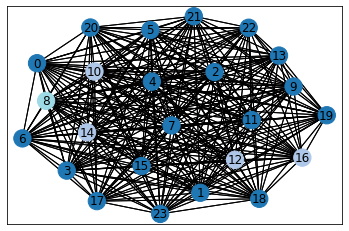

In [122]:
draw_dgl_graph(
    mol_to_complete_graph(mol, node_featurizer=PretrainAtomFeaturizer()),
    'atomic_number')

BERT/Transformer를 좀 공부하신 분들은, 위 그래프가 반갑고 친근하실 수 있습니다. 

Self-attention은 곧 자기 자신 (sequence) 내 모든 token (node) 들이 서로 fully-connected된 에서 msg주고받는것이기 때문입니다.


**Self attention for one token**

<img src='https://drive.google.com/uc?id=1EQOVNhaAwAsU3f5h5j8BHXeohg4daGTq' height=160/>

Ainslie et al., 2020

---

**Self attention for all tokens**

<img src='https://i.imgur.com/zV5LmTX.png' height=160 />

Wang et al., 2019






In [123]:
def smiles2molgraph(smiles: str): # SMILES가 단수인지 복수인지 애매하니 되도록 type hint
    try:
        mol = Chem.MolFromSmiles(smiles)
        g = molgraph(mol)
    except:
        # 실패하는 mol은 그냥 무시하기
        g = None
    return g

%time graphs = [x for x in list(map(smiles2molgraph, df['smiles'])) if x is not None]

CPU times: user 9.9 s, sys: 61.4 ms, total: 9.96 s
Wall time: 9.99 s


In [124]:
graphs[:4]

[Graph(num_nodes=24, num_edges=78,
       ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=33, num_edges=103,
       ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=21, num_edges=67,
       ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)}),
 Graph(num_nodes=28, num_edges=90,
       ndata_schemes={'atomic_number': Scheme(shape=(), dtype=to

## Dataloading

앞서 말씀드린 collate_fn을 다룰 때가 왔습니다. 

저희가 바라는 fn: `[g1, g2, ... gN]`을 input으로 받고, 하나의 `batch` 뭉치를 받기 원합니다.

다행히 DGL에 편리한 `batch` fn 이 존재합니다.



    Batch a collection of :class:`DGLGraph` s into one graph for more efficient
    graph computation.

    Each input graph becomes one disjoint component of the batched graph. The nodes
    and edges are relabeled to be disjoint segments:

    =================  =========  =================  ===  =========
                       graphs[0]  graphs[1]          ...  graphs[k]
    =================  =========  =================  ===  =========
    Original node ID   0 ~ N_0    0 ~ N_1            ...  0 ~ N_k
    New node ID        0 ~ N_0    N_0+1 ~ N_0+N_1+1  ...  1+\sum_{i=0}^{k-1} N_i ~
                                                          1+\sum_{i=0}^k N_i
    =================  =========  =================  ===  =========


참고: https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html

In [125]:
# print(dgl.batch.__doc__)

In [245]:
# batch graphs
bg = dgl.batch([graphs[i] for i in range(3)])

Graph(num_nodes=78, num_edges=248,
      ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)})

좀더 가시적으로 확인해보면, batch된 graph는 하나의 dgl.DGLGraph 오브젝트이지만, 이 안에는 n개의 graph 정보가 내재되어 있습니다. Batching 방식은, node/edge feature는 바로 concatenate, 그리고 edge를 정의하는 adjacency matrix는 diagonally concatenate하는 것입니다.

<img src='https://drive.google.com/uc?id=1pisw98_0QL5kbrfmVzhGiETnALGDkiOo' height=100/>

이런 batching의 장점은

1. message passing정의에 변형 전혀 없이 신경망을 그대로 적용할 수 있다 (message가 subgraph간 오염이 될 리가 없으니)
2. padding, truncation걱정할 것 없다

https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html


Adjacency matrix를 그려보면, graph의 경계선을 넘는 edge는 없다고 확인할 수 있습니다


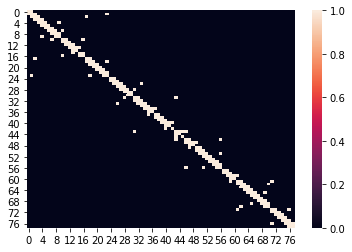

In [235]:
# Create adj matrix
A = bg.adj(scipy_fmt='coo').todense()
sns.heatmap(A)

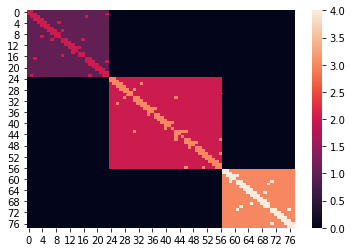

In [236]:
# mark graph bounds and viz
c = 0
for i, n in enumerate(bg.batch_num_nodes()):
    A[c:n+c, c:n+c] += i + 1
    c+=n
sns.heatmap(A)

그래프를 그려봐도, 서로 떨어져 있다는 것이 확인 됩니다.

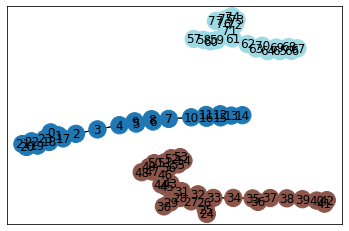

In [249]:
# featurize nodes by graph idx
g_idxs = []
for i, n in enumerate(bg.batch_num_nodes()):
    g_idxs.append(th.repeat_interleave(th.tensor([i]), n))
bg.ndata['feat'] = th.cat(g_idxs)
bg.ndata['feat']

# visualize
draw_dgl_graph(bg, pos=nx.spring_layout(bg.to_networkx(),
                                        iterations=150))

graph collation은 `dgl.batch`로 처리할 수 있고, 그 외 데이터 (y tensor 또는 SMILES str등)은 list 또는 tensor.cat/stack으로 쉽게 처리 가능합니다.

위에서 정의한 dataframe과 featurize한 molgraph들을 합쳐서 dataset을 만들어보고, 이를 batching할 수 있는 collate_fn을 작성해보겠습니다.

In [128]:
df.head()

,exp,smiles
0,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [129]:
# df값들을 array로 받고...
df.values.T

array([[3.54, -1.18, 3.69, ..., 2.1, 2.65, 2.7],
       ['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14',
        'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23',
        'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', ...,
        'COc1cccc2[nH]ncc12', 'Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3',
        'CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N']], dtype=object)

In [130]:
# zip으로 graph들과 합침
dataset = list(zip(graphs, *df.values.T))
dataset[0]

(Graph(num_nodes=24, num_edges=78,
       ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)}),
 3.54,
 'Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14')

In [131]:
# 위 dataset zipping을 그대로 꺼꾸로 풀어주는데, graph는 batch하고 y값은 tensor로
def my_collate_fn(datums):
    graphs, ys, smiles = list(zip(*datums))
    return smiles, dgl.batch(graphs), th.tensor(ys)

In [132]:
import torch 
from torch.utils.data import DataLoader

# 위에 정의한 collate_fn 사용...
dl = DataLoader(dataset, batch_size=8, collate_fn=my_collate_fn, shuffle=True)

ex_batch = next(iter(dl))
ex_batch

(('Cn1cncc1c2c3C(=O)N(CC=C)C(=O)N(CC4CC4)c3nn2Cc5ccnc6ccc(Cl)cc56',
  'CC(C)CN1C(=O)N(C)C(=O)c2c(SC3CCCCC3)c(Cc4ccccc4C(F)(F)F)sc12',
  'COc1ccc(F)c(F)c1C(=O)c2cnc(NC3CCN(CC3)S(=O)(=O)C)nc2N',
  'Clc1ccc(cc1C(=O)NCC23CC4CC(CC(C4)C2)C3)N5N=CC(=O)NC5=O',
  'CN1C(=O)N(CC2CC2)c3nn(Cc4ccnc5ccc(Cl)cc45)c(c3C1=O)c6nc(cn6C)S(=O)(=O)C',
  'CC(C)NNC(=O)c1ccncc1',
  'CC(C)c1c(cnn1c2ccc(cc2)C(=O)O)C(=O)NC3C4CC5CC(CC3C5)C4',
  'Oc1ccc(cc1)c2oc3cc(O)ccc3n2'),
 Graph(num_nodes=227, num_edges=731,
       ndata_schemes={'atomic_number': Scheme(shape=(), dtype=torch.int64), 'chirality_type': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'bond_type': Scheme(shape=(), dtype=torch.int64), 'bond_direction_type': Scheme(shape=(), dtype=torch.int64)}),
 tensor([3.6200, 4.1400, 2.0800, 2.1000, 2.6400, 0.3300, 1.1500, 3.3000]))

어떤경우에는 Y값이 없거나 필요없는 dataloader도 있겠지요. inference하여 prediction을 뽑거나, 그냥 embedding만 얻고싶거나.

중요한 점은, **collater는 내 데이터와 모델을 연결해주는 mini pipeline**, 내 데이터 형태와 모델이 바라는 데이터 유형에 따라 얼마든지 flexible할 수 있습니다. 몇가지 예시를 보시려면 dgl, ogb, [pytorch_geometric](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/dataloader.html) 소스코드 좀 뒤져보시면 어느정도 패턴이 보입니다.

### Homework
- 위와 동일하지만 y를 무시하는 collate_fn 만들어보세요.

---
이제 드디어 첫 GNN이 등장합니다. "왜이렇게 데이터만 만지작 거리고 AI수업에 신경망은 없냐?" 생각하실 수 있지만, AI의 Rule 0를 잊지 마시길 바랍니다:

> "Become one with the data"


<img src='https://img.cinemablend.com/filter:scale/quill/b/f/c/9/e/a/bfc9ea0491efca53eec2350421e1911d07120072.jpg?mw=600' height=200/>


다들 아시겠지만, 정말 지겨울정도로 데이터를 만지다 보면 어떤 신경망이 그 위에 얹혀져야할지는 당연스레 드러납니다. 

<font color='red'>**SOTA모델은 매주 바뀌지만, SOTA데이터는 10년단위로 바뀝니다**</font>

# Simple GNN for Molecules

구조가 간단하고 baseline으로 나쁘지 않은 GIN-e 사용하도록 하겠습니다. 아래와 같은 update를 갖고 있네요.

\begin{equation}
x_v^{(l+1)} = \text{MLP}_θ^{(l+1)} \left( (1+ε) \cdot x_v^{(l)} + \sum_{w\in \mathcal{N}(v)} x_w^{(l)}  + e^{(l)}_{w,v}\right)
\end{equation}


Fey et al., 2020


<img src='https://drive.google.com/uc?id=1nxtdwDxGcilJyZOgvL4U-iiW5Ba8RW81' height=320/>

Dwivedi et al., 2020


In [133]:
from dgllife.model import GIN

gin = GIN(num_node_emb_list=[120, 3], # 이숫자들! 어디서 온것일까요? Hint: featurizer를 드려다 보세요
          num_edge_emb_list=[6, 3],
          # hyperparameters
          num_layers=2,
          emb_dim=256,
          JK='last', # jumping knowledge, resnet의 재발견과 약간 비슷한 개념
          dropout=0.1)
gin

GIN(
  (dropout): Dropout(p=0.1, inplace=False)
  (node_embeddings): ModuleList(
    (0): Embedding(120, 256)
    (1): Embedding(3, 256)
  )
  (gnn_layers): ModuleList(
    (0): GINLayer(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
      (edge_embeddings): ModuleList(
        (0): Embedding(6, 256)
        (1): Embedding(3, 256)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GINLayer(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=256, bias=True)
      )
      (edge_embeddings): ModuleList(
        (0): Embedding(6, 256)
        (1): Embedding(3, 256)
      )
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [134]:
from operator import itemgetter

# 이게 왜 python 기본적으로 없는지...
nget = itemgetter('atomic_number', 'chirality_type')
eget = itemgetter('bond_type', 'bond_direction_type')


g = ex_batch[1]
out = gin(g, nget(g.ndata), eget(g.edata))
print(out.shape)
out

torch.Size([227, 256])


tensor([[ 1.0527, -0.9089, -1.1723,  ..., -0.9115, -0.1975, -0.1372],
        [ 0.3137, -0.4144, -0.0080,  ..., -0.3630, -0.7128,  0.2858],
        [-0.2338, -0.5176,  0.5465,  ..., -0.8726,  0.3647,  0.9399],
        ...,
        [-0.7131, -0.0000, -0.3017,  ..., -0.6753,  1.4890,  1.0937],
        [-1.2685, -0.1024,  0.0000,  ..., -0.0000,  1.9479,  1.3488],
        [-0.1210, -0.9326, -0.1081,  ..., -0.9781,  1.3632,  0.7874]],
       grad_fn=<MulBackward0>)

In [135]:
class MolEmbWrapper(nn.Module):
    def __init__(self, net, ngetter, egetter):
        super().__init__()
        self.nget = ngetter
        self.eget = egetter
        self.net = net

    def forward(self, g):
        return self.net(g, 
                        self.nget(g.ndata), 
                        self.eget(g.edata))

In [239]:
mew = MolEmbWrapper(gin, nget, eget)
g_embs = mew(g)

In [242]:
g_embs

tensor([[ 1.0110, -0.9321, -1.3451,  ..., -0.9974, -0.3964,  0.1075],
        [ 0.2245, -0.2099,  0.0000,  ..., -0.9377, -0.8571,  0.2257],
        [-0.1961, -0.6296,  0.6367,  ..., -1.0847,  0.3134,  1.0641],
        ...,
        [-0.4615, -0.6726, -0.2765,  ..., -0.9242,  1.7748,  0.7565],
        [-0.4570,  0.4623,  1.6741,  ..., -1.6209,  1.5490,  1.2344],
        [-0.1108, -0.8082,  0.4449,  ..., -1.1737,  1.1177,  0.8430]],
       grad_fn=<MulBackward0>)

In [241]:
g_embs.shape

torch.Size([227, 256])

In [243]:
ex_batch[-1]

tensor([3.6200, 4.1400, 2.0800, 2.1000, 2.6400, 0.3300, 1.1500, 3.3000])

분명히 8개짜리 batch를 collate하여 입력했는데, 출력값은 batch dimension이 안보이네요... 

이 모양의 Mismatch는 왜일까요?

In [139]:
g.batch_num_nodes()

tensor([36, 34, 30, 29, 38, 13, 30, 17])

graph batch의 node/edge feature들은 1D로 쭉 늘어나지, batch dimension이 추가되지 않습니다. batch 내 어느 sample의 node인지에 대한 정보는 adjacency matrix (edge indices)에 포함되어 있는것이지, 다른 tensor처럼 batch dimension이 따로 있지 않습니다.

Batch 단위 연산을 하고싶다면, scatter/gather operation이 필요하게 됩니다.

이는 사각형 tensor보다 조금 더 복잡하단 단점이 있지만, padding/truncation 걱정이 사라지는 장점이 있습니다.

<img src='https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true' height=200/>

https://github.com/rusty1s/pytorch_scatter

In [141]:
from dgl.readout import readout_nodes
from dgllife.model import MLPNodeReadout

g.ndata['out'] = out
mean_out = readout_nodes(g, 'out', op='mean')

In [153]:
mean_out.shape

torch.Size([8, 256])

Readout해주니 기대되는 y의 모양 (즉 num_graphs 수)과 일치하네요. 

왜 다른 모델에서 하듯 `torch.mean(x, dim=-1)` 하면 안될까요?

## Homework
- MLPNodeReadout, Set2Set readout, AttentiveFP readout 등 적용시켜보기 

## Inference with Pretrained Mol Encoder

In [143]:
from dgllife.model import load_pretrained

mol_model = load_pretrained('gin_supervised_infomax').cuda()
mol_model = mol_model.eval()
# print(mol_model)

Pretrained model loaded


In [144]:
# 아까 숙제라고 했지만 하나 예시...
def embedder_collate_fn(datums):
    graphs, _, smiles = list(zip(*datums))
    return smiles, dgl.batch(graphs)

In [145]:
def embed_mol(net, g):
    # net을 활용해서 g를 embed 한다. 유의할점은 cuda부르는 것 (실제코드에서는 이렇게 manual하게 안함), 
    # 그리고 ndata/edata의 datakey들이 하드코딩 됬다는 점 (실제코드에선 이렇게 brittle하게 안함).
    g = g.to(th.device('cuda:0'))
    nf = [g.ndata['atomic_number'].cuda(),
          g.ndata['chirality_type'].cuda()]
    ef = [g.edata['bond_type'].cuda(),
          g.edata['bond_direction_type'].cuda()]
    with th.no_grad():
        return net.cuda()(g, nf, ef)

In [80]:
from tqdm import tqdm

dl = DataLoader(dataset, batch_size=32, collate_fn=embedder_collate_fn, shuffle=True)

smiles = []
embs = []
for i, (smi, g) in tqdm(enumerate(dl)):
    emb = embed_mol(mol_model, g)
    embs.extend(emb)
    smiles.extend(smi)

132it [00:01, 67.22it/s]


In [81]:
len(smiles), len(embs)

(4200, 113568)

왜 SMILES보다 embedded mols가 더 많은지는 이제 아시지요?

바로 readout을 하지 않고, 이렇게 node별 hidden representation을 유지하는데에 장점이 있을까요?

1. node level pretraining
2. node level prediction
3. node aware graph level prediction

# Protein Repr. with Transformers

NLP툴체인/아키텍쳐로 단백직서열으로 처리하는 연구는 많이 진행되고있습니다.


- [ProtTrans](https://github.com/agemagician/ProtTrans)
    - 2.1B protein sequences (~400B amino acids) + Transformer => train on TPU pods and Summit supercomputer => pretrained models
- [BERTology meets Biology](https://www.biorxiv.org/content/10.1101/2020.06.26.174417v1?rss=1)

In [82]:
from transformers import BertTokenizer, BertModel
import re
import numpy as np
import gc

class PretrainedProteinEmbed(nn.Module):
    def __init__(self, id='Rostlab/prot_bert', device='cuda:0'):
        """
        Download and load pretrained huggingface transformer model.
        See: https://www.biorxiv.org/content/10.1101/2020.07.12.199554v2
        """
        super().__init__()
        self.device = th.device(device)
        # loading happens here
        self.model = BertModel.from_pretrained(id).to(self.device).eval()
        self.tokenizer = BertTokenizer.from_pretrained(id, do_lower_case=False)
        gc.collect()

    def process_str(self, s):
        s = re.sub(r'\s', '', s)
        x = str.join(' ', list(re.sub(r' ', '', s.upper())))
        x = re.sub(r'[UZOB]', 'X', x)
        return x

    def process_seqs(self, seqs):
        """
        Process sequence for input into model
        """
        seqs = [self.process_str(s) for s in seqs]
        ids = self.tokenizer.batch_encode_plus(
            seqs, add_special_tokens=True, pad_to_max_length=True)
        input_ids = th.tensor(ids['input_ids']).to(self.device)
        attn_mask = th.tensor(ids['attention_mask']).to(self.device)
        return input_ids, attn_mask

    def forward(self, sequences):
        """
        Forward pass, outputting embeddings
        """
        in_ids, attn_mask = self.process_seqs(sequences)
        with th.no_grad():
            embeddings = self.model(input_ids=in_ids,
                                    attention_mask=attn_mask)[0]
        return embeddings * attn_mask.unsqueeze(-1)
    
    def postprocess_embeddings(self, embeddings):
        """
        Remove CLS, SEP, PAD tokens from output embedding.
        """
        features = []
        for i, emb in enumerate(embeddings):
            seq_len = (attn_mask[i] == 1).sum()
            features.append(emb[1:seq_len-1])
        return features

In [83]:
def count_params(model: nn.Module):
    """
    Counts the number of trainable parameters in given model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [84]:
ppe = PretrainedProteinEmbed()

In [85]:
# protein model is much larger, paramter-wise
count_params(ppe) // count_params(mol_model)

226

테스팅 용으로 UniProt에서 EGFR sequence를 받아와 봅니다.

https://www.uniprot.org/uniprot/P00533.fasta

In [86]:
egfr = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
APQSSEFIGA"""

In [87]:
ppe.process_str(egfr)

'M R P S G T A G A A L L A L L A A L C P A S R A L E E K K V C Q G T S N K L T Q L G T F E D H F L S L Q R M F N N C E V V L G N L E I T Y V Q R N Y D L S F L K T I Q E V A G Y V L I A L N T V E R I P L E N L Q I I R G N M Y Y E N S Y A L A V L S N Y D A N K T G L K E L P M R N L Q E I L H G A V R F S N N P A L C N V E S I Q W R D I V S S D F L S N M S M D F Q N H L G S C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D G V R K C K K C E G P C R K V C N G I G I G E F K D S L S I N A T N I K H F K N C T S I S G D L H I L P V A F R G D S F T H T P P L D P Q E L D I L K T V K E I T G F L L I Q A W P E N R T D L H A F E N L E I I R G R T K Q H G Q F S L A V V S L N I T S L G L R S L K E I S D G D V I I S G N K N L C Y A N T I N W K K L F G T S G Q K T K I I S N R G E N S C K

In [88]:
ppe([egfr])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([[[ 1.3019e-01,  6.0025e-02,  7.7961e-02,  ..., -9.4421e-02,
           1.6033e-04, -9.5430e-03],
         [ 4.5659e-02, -1.1708e-02, -1.4669e-01,  ...,  4.3669e-02,
           6.0659e-02, -9.0526e-02],
         [ 1.1839e-01,  7.6940e-02, -3.8128e-02,  ...,  9.2220e-02,
          -1.3974e-01, -4.3242e-02],
         ...,
         [ 6.6020e-02, -3.2431e-02,  1.7804e-01,  ...,  1.6731e-01,
          -9.9195e-02, -1.2446e-01],
         [ 1.4298e-01,  4.4622e-02,  1.1772e-01,  ...,  1.3067e-01,
          -6.2030e-02, -9.9651e-02],
         [ 7.6950e-02, -4.3625e-02,  3.9496e-02,  ..., -7.2713e-02,
          -4.4393e-02,  6.1550e-02]]], device='cuda:0')

### Homework

- 본인 연구 관심있으신 단백질서열 embedding 진행해보시오


지금까지 배운개념들 Review:

1. Molecule을 SMILES로 부터 자유자제로 featurization
2. Featurized molecular graph를 처리할 수 있는 GNN
3. GNN의 output은 atom (node) level, molecule (graph) level 둘다 가능
4. AA seq를 읽어들이는 Transformer
5. Protein Transformer output 마찬가지로 aa단위, sequence 단위 

# Chemical + Protein => Interaction

chemical과 protein의 representation을 합쳐서 그들의 interaction을 예측하려면 어떤 접근이 가능할까?

1. concat => MLP

    <img src='https://github.com/hkmztrk/DeepDTA/raw/master/docs/figures/deepdta.PNG' height=200/>
    
    Ozturk et al., 2018

2. embed to same space (w/ co-attention) => cosine distance

    <img src='https://drive.google.com/uc?id=1RDD8Ny2zhX3Tp5FAUu8H0szZSU5J9zl6' height=300/>

    Weng et al., 2019

3. dual attention network

    <img src='https://drive.google.com/uc?id=1y8SoFlmTvcBURyrG93ayM1P8_EA0Fj4Z' height=300 />

    Nam et al., 2017

4. ...

## Concat then MLP

In [89]:
class ConcatInteraction(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inner_dim = dim // 2
        self.layers = nn.Sequential(
            nn.Linear(dim, inner_dim),
            nn.BatchNorm1d(inner_dim),
            nn.ReLU(),
            nn.Linear(inner_dim, 1)
        )
    
    def forward(self, c, p, op='mean'):
        c_readout = readout_nodes(c, 'out', op=op)
        p_readout = p.mean(-2)
        return self.layers(th.cat([c_readout, p_readout], dim=-1))


class DTIModel(nn.Module):
    def __init__(self, mol_embed, prot_embed, interaction):
        super().__init__()
        self.mol_embedder = MolEmbWrapper(mol_embed, nget, eget)
        self.prot_embedder = prot_embed
        self.interaction = interaction

    def forward(self, mol, prot, op='mean'):
        m = self.mol_embedder(mol)
        mol.ndata['out'] = m
        p = self.prot_embedder(prot)

        # interaction
        interaction = self.interaction(mol, p)
        return interaction

In [90]:
concat_interaction = ConcatInteraction(300 + 1024)
concat_interaction

ConcatInteraction(
  (layers): Sequential(
    (0): Linear(in_features=1324, out_features=662, bias=True)
    (1): BatchNorm1d(662, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=662, out_features=1, bias=True)
  )
)

In [91]:
dti_net = DTIModel(mol_model, ppe, concat_interaction).cuda()

In [92]:
mols = ex_batch[1].to('cuda:0')

In [93]:
dti_net(mols, [egfr] * 8)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([[ 0.0995],
        [-0.1107],
        [-0.4438],
        [ 0.3488],
        [ 0.1236],
        [-0.0561],
        [-0.5662],
        [ 0.0548]], device='cuda:0', grad_fn=<AddmmBackward>)

## Attention Pooling

Task: 두 개 (길이가 다른) input이 주어질 시, 서로간의 상호관계를 활용하여 각 input의 pooled representation을 만들 수 있을까?

"Q"이 주어질 때 여러가지 candidate 답변 중 가장 적합한 답변을 찾는 과제 ~= virtual screening?

<img src='https://drive.google.com/uc?id=1rgpFRS9N4c52PQ2TIPEhkPQAKVjPJDy1' height=500/>

dos Santos et al., 2016

In [94]:
Q = th.randn(17, 1024)
A = th.randn(8, 300)
U = th.randn(1024, 300)

scaling = (300 * 1024) ** 0.5

In [95]:
G = th.tanh((Q @ U) @ A.T)
Gs = th.tanh(((Q @ U) @ A.T / scaling))

Why use scaling factor?

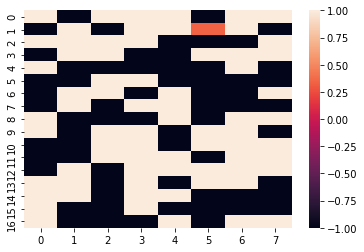

In [253]:
sns.heatmap(G)

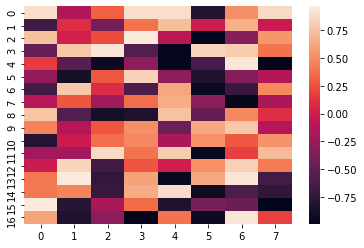

In [252]:
sns.heatmap(Gs)

In [98]:
class AttentionPooling(nn.Module):
    def __init__(self, q_dim, a_dim):
        super().__init__()
        self.U = nn.Parameter(th.randn(q_dim, a_dim))
        self.scaling = (q_dim * a_dim) ** 0.5

    def forward(self, q, a):
        G = th.einsum('...nd,dh,...mh->...nm', q, self.U, a)
        G = th.tanh(G / scaling)

        q_weights = th.softmax(G.max(-1)[0], -1)
        a_weights = th.softmax(G.max(-2)[0], -1)

        Q = th.einsum('...n,...nd->...d', q_weights, q)
        A = th.einsum('...n,...nd->...d', a_weights, a)

        return Q, A

In [99]:
ap = AttentionPooling(300, 1024)

q = th.randn(3, 10, 300)
a = th.randn(3, 15, 1024)
Q, A = ap(q, a)

Q.shape, A.shape

(torch.Size([3, 300]), torch.Size([3, 1024]))

## Siamese Net

<img src='https://drive.google.com/uc?id=1kHQuJj3Z9U9Yqs_aebAYnqA8Io8dh-D4' height=300/>

Gao et al., 2018

In [146]:
class AttnPoolSiamese(nn.Module):
    """
    Attentive pooling for mol/prot followed by MLP projection and cosine 
    similarity measure.
    """

    def __init__(self, q_dim, a_dim, dim):
        super().__init__()
        self.attn_pool = AttentionPooling(q_dim, a_dim)
        self.q_mlp = nn.Sequential(nn.Linear(q_dim, dim),
                                   nn.ReLU(),
                                   nn.Linear(dim, dim))
        self.a_mlp = nn.Sequential(nn.Linear(a_dim, dim),
                                   nn.ReLU(),
                                   nn.Linear(dim, dim))
        self.similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, mol, prot):
        # batching and padding of mol
        splits = th.split(mol.ndata['out'], 
                          tuple(mols.batch_num_nodes().cpu().numpy()),
                          dim=0)
        batched = nn.utils.rnn.pad_sequence(splits, batch_first=True)

        # co-attn => cosine-sim
        Q, A = self.attn_pool(batched, prot)
        Q = self.q_mlp(Q)
        A = self.a_mlp(A)
        return self.similarity(Q, A)

In [147]:
apsim = AttnPoolSiamese(300, 1024, 512)

In [148]:
dti_w_siam = DTIModel(mol_model, ppe, apsim).cuda()

In [149]:
out = dti_w_siam(mols, [egfr] * 8)
out

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tensor([ 0.0151,  0.0175,  0.0282,  0.0308,  0.0192, -0.0093,  0.0534,  0.0562],
       device='cuda:0', grad_fn=<DivBackward0>)